In [1]:
from math import sqrt, atan2, cos, sin
import numpy as np
from numpy import deg2rad, rad2deg

In [2]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)

In [3]:
from common import *

## Initial state

In [4]:
tilt = Vector2(0, 0)
pos = Vector2(0, 0)
direction = Vector2(0, 1)
next_wp = Vector2(20, 20)

speed = 5.0
maxspeed = 30.0

omega = 0

max_yaw_speed = max_pitch_speed = deg2rad(90)
angular_mobility = 2.0

In [5]:
theta0 = (next_wp - pos).angle_to(direction)

In [6]:
def to_local(pos, target, direction):
    target_rel = target - pos
    angle = direction.angle_to(target_rel)
    return Vector2(0, 1).rotated(angle)

def to_global(pos, target_rel, direction):
    angle = Vector2(0, 1).angle_to(target_rel)
    return pos + direction.rotated(angle)

print(to_local(pos, next_wp, direction))
print(to_local(pos, next_wp, Vector2(1, 0)))

(0.7071067811865476, 0.7071067811865476)
(-0.7071067811865476, 0.7071067811865476)


In [7]:
def d_theta(angle, ETA, omega, e, t):
    # z0 = angle / ETA - omega
    # s = np.sign(z0)
    # return z0 + s * e * t
    return angle / ETA - omega + e * t

def full_theta(angle, ETA, omega, e, t):
    k = angle + omega * ETA + e * ETA * ETA
    return angle - e * t * ETA + k * (np.exp(t / ETA) - 1)

def d_full_theta(angle, ETA, omega, e, t):
    k = angle + omega * ETA + e * ETA * ETA
    return -e * ETA + k / ETA * np.exp(t / ETA)

In [8]:
N = 1000
ETA = abs(next_wp - pos) / speed
print(ETA)

ts = np.linspace(0, 1, N)
thetas = full_theta(theta0, ETA, omega, max_yaw_speed, ts)
dt1 = np.array([d_theta(th, ETA, omega, max_yaw_speed, t) for t, th in zip(ts, thetas)])
dt2 = d_full_theta(theta0, ETA, omega, max_yaw_speed, ts)

5.656854249492381


In [9]:
a = d_theta(0.1, ETA, omega, max_yaw_speed, 1)
b = d_theta(0.2, ETA, omega, max_yaw_speed, 1)
print(a, b)

1.5884739963245602 1.6061516658542239


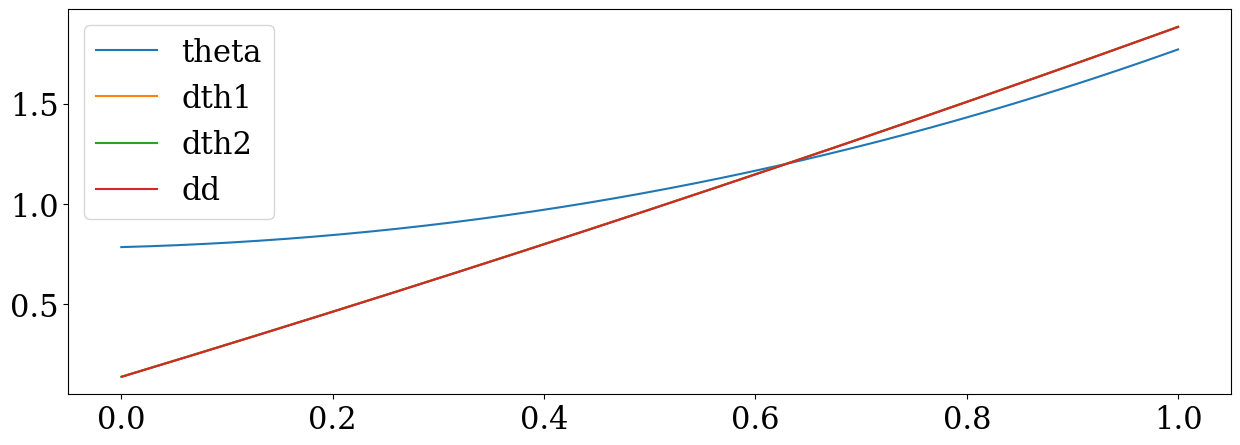

In [10]:
plt.plot(ts, thetas, label='theta')
plt.plot(ts, dt1, label='dth1')
plt.plot(ts, dt2, label='dth2')
plt.plot(ts[1:], np.diff(thetas) / np.diff(ts), label='dd')
plt.legend(loc='upper left')
plt.show()

## Simulation

In [11]:
def simulate_plain(pos, target, speed, direction, ts):
    coords = np.array([pos + direction * speed * t for t in ts])
    angles = np.array([(target - p).angle_to(direction) for p in coords])
    return angles, coords

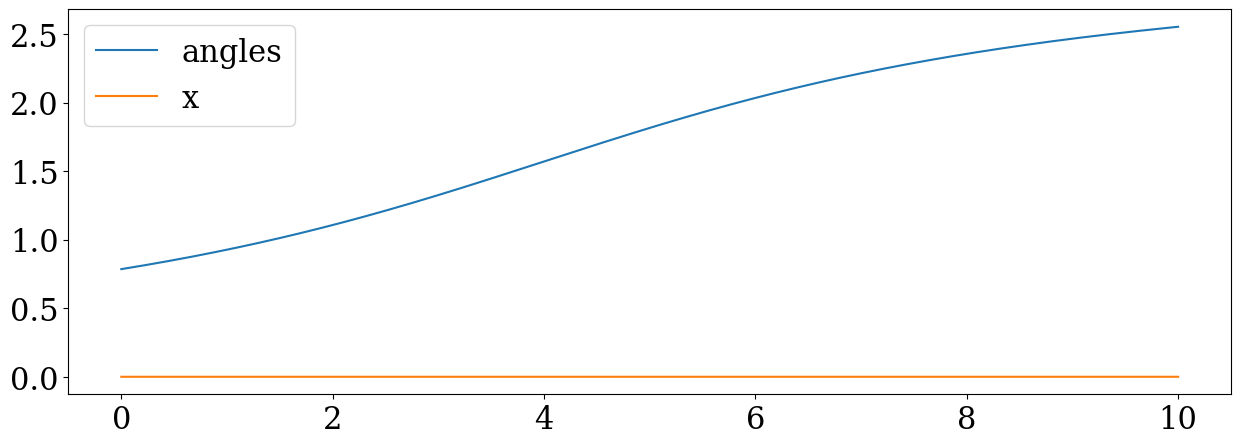

In [12]:
N = 10000
ts = np.linspace(0, 10, N)
ths, xs = simulate_plain(pos, next_wp, speed, direction, ts)

plt.plot(ts, ths, label='angles')
plt.plot(ts, [x.x for x in xs], label='x')
# plt.plot(ts, [x.z for x in xs], label='z')
plt.legend(loc='upper left')
plt.show()

In [13]:
def simulate_omega(pos, target, speed, direction, omega, ts):
    s = np.sign(omega)
    R = speed / omega
    center = pos - direction.rotated(np.pi / 2) * R
    rad = pos - center
    coords = np.array([center + rad.rotated(-t * omega) for t in ts])
    directions = np.array([direction.rotated(-t * omega) for t in ts])
    angles = np.array([(target - p).angle_to(d) for p, d in zip(coords, directions)])
    return angles, coords, directions

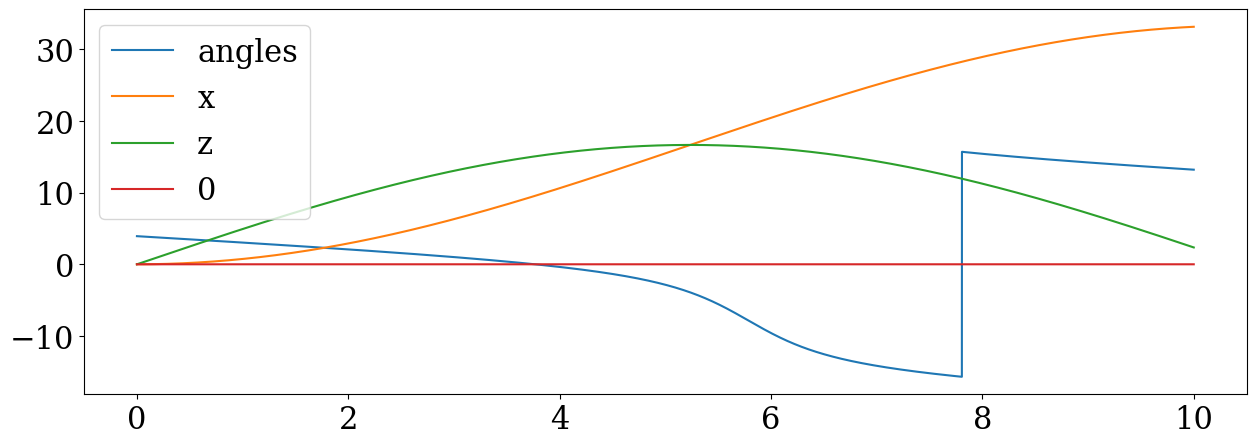

In [14]:
omega = 0.3
ths, xs, ds = simulate_omega(pos, next_wp, speed, direction, omega, ts)

plt.plot(ts, ths * 5, label='angles')
plt.plot(ts, [x.x for x in xs], label='x')
plt.plot(ts, [x.z for x in xs], label='z')
plt.plot(ts, ts * 0, label='0')
plt.legend(loc='upper left')
plt.show()

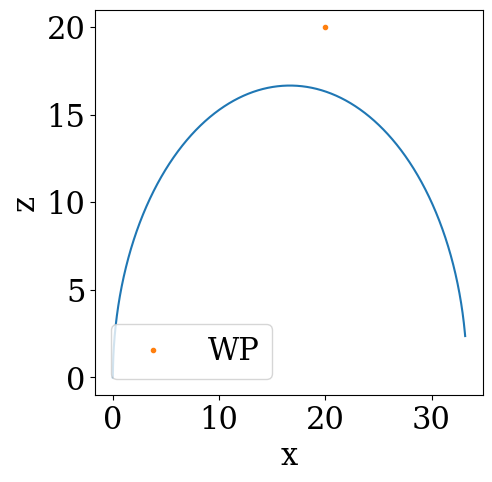

In [15]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([x.x for x in xs], [x.z for x in xs])
plt.plot(next_wp.x, next_wp.z, '.', label='WP')
plt.legend(loc='lower left')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

In [16]:
def simulate_omega_dt(pos, target, speed, direction, omega, T, dt=1e-3, decimate=1):
    t = 0
    p = pos
    d = direction
    coords = []
    directions = []
    di = 1
    while t < T:
        if di % decimate == 0:
            coords.append(p)
            directions.append(d)
        di += 1

        d = d.rotated(-dt * omega)
        p += d * speed * dt
        t += dt
    
    angles = np.array([(target - p).angle_to(d) for p, d in zip(coords, directions)])
    return angles, np.array(coords), np.array(directions)

In [17]:
omega = 0.2
dt = np.diff(ts)[0]
ths1, xs1, ds2 = simulate_omega(pos, next_wp, speed, direction, omega, ts)
ths2, xs2, ds2 = simulate_omega_dt(pos, next_wp, speed, direction, omega, ts[-1] + dt, dt / 10, decimate=10)
xs1.shape, xs2.shape

((10000,), (10000,))

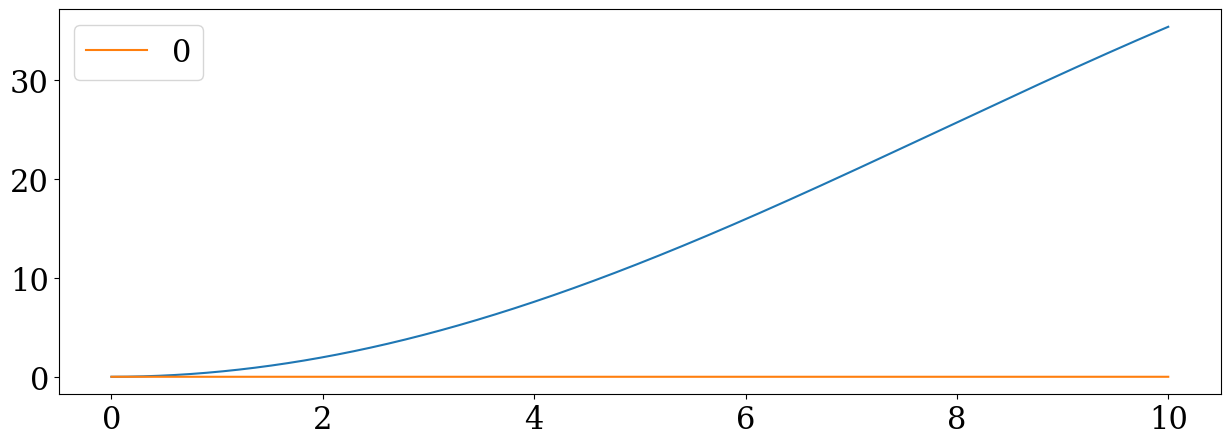

In [18]:
# plt.plot(ts, ths1 - ths2, label='angles diff')
# plt.plot(ts, [x.x for x in (xs1 - xs2)], label='x diff')
# plt.plot(ts, [x.z for x in (xs1 - xs2)], label='z diff')
plt.plot(ts, [x.x for x in xs2])
plt.plot(ts, ts * 0, label='0')
plt.legend(loc='upper left')
plt.show()

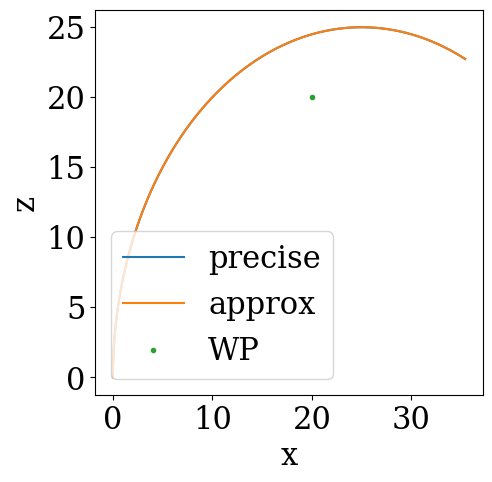

In [19]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([x.x for x in xs1], [x.z for x in xs1], label='precise')
plt.plot([x.x for x in xs2], [x.z for x in xs2], label='approx')
plt.plot(next_wp.x, next_wp.z, '.', label='WP')
plt.legend(loc='lower left')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

In [20]:
def simulate_omega_eps_dt(pos, target, speed, direction, omega, eps, T, dt=1e-3, decimate=1):
    t = 0
    p = pos
    w = omega
    d = direction
    coords = []
    directions = []
    di = 1
    while t < T:
        if di % decimate == 0:
            coords.append(p)
            directions.append(d)
        di += 1

        d = d.rotated(-dt * w)
        p += d * speed * dt
        w += eps * dt
        t += dt
    
    angles = np.array([(target - p).angle_to(d) for p, d in zip(coords, directions)])
    return angles, np.array(coords), np.array(directions)

In [21]:
omega0 = 0
eps = 0.1
t1 = 4.9
dt = 1e-2
ths1, xs1, ds1 = simulate_omega_eps_dt(pos, next_wp, speed, direction, omega0, eps, t1, dt, decimate=1)
pos2 = xs1[-1]
dir2 = ds1[-1]
t2 = 7.2 - t1
ths2, xs2, ds2 = simulate_omega_eps_dt(pos2, next_wp, speed, dir2, omega0 + eps * t1, -eps, t2, dt, decimate=1)

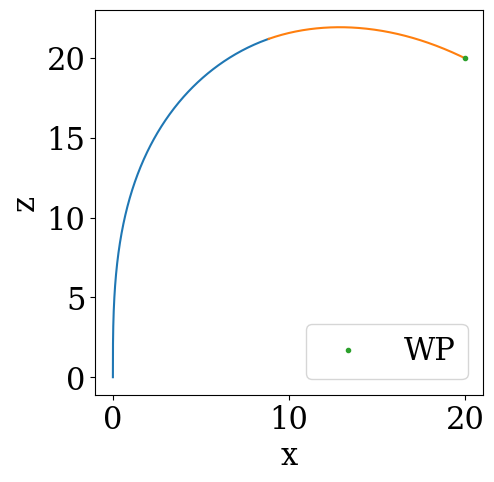

In [22]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([x.x for x in xs1], [x.z for x in xs1])
plt.plot([x.x for x in xs2], [x.z for x in xs2])
plt.plot(next_wp.x, next_wp.z, '.', label='WP')
plt.legend(loc='lower right')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

## Strategy research

In [23]:
ths = np.concatenate([ths1, ths2])
xs = np.concatenate([xs1, xs2])
ds = np.concatenate([ds1, ds2])
strategy = np.concatenate([np.zeros_like(xs1), np.ones_like(xs2)])
ts = np.arange(0, dt * xs.shape[0], dt)
ts1 = ts[:xs1.shape[0]]
ts2 = ts[:xs2.shape[0]]
ws = omega0 + np.concatenate([[eps * t for t in ts1], [eps * (xs1.shape[0] * dt - t) for t in ts2]])

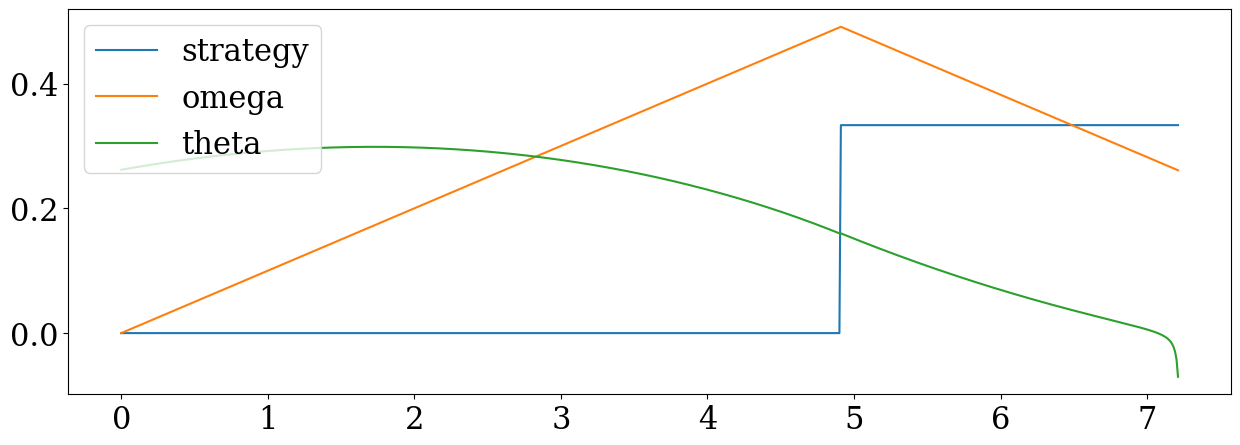

In [24]:
plt.plot(ts, strategy / 3, label='strategy')
plt.plot(ts, ws, label='omega')
plt.plot(ts, ths / 3, label='theta')
plt.legend(loc='upper left')
plt.show()

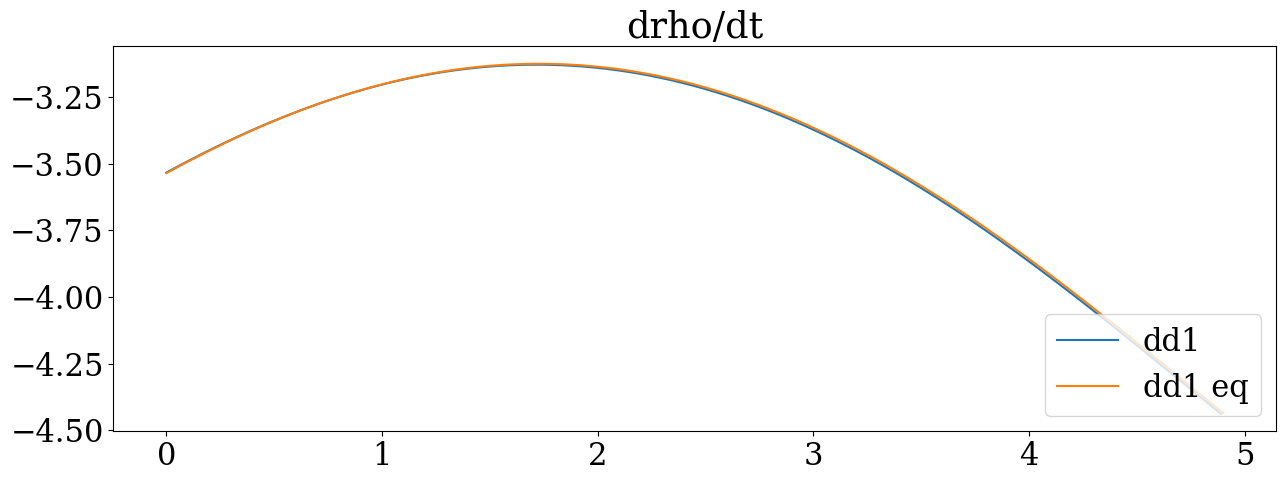

In [25]:
dists1 = np.array([abs(x - next_wp) for x in xs1])

ddists1 = np.diff(dists1) / dt
ddists1_eq = np.array([-speed * np.cos(th) for th in ths1])

plt.title("drho/dt")
plt.plot(ts1[:-1], ddists1, label='dd1')
plt.plot(ts1, ddists1_eq, label='dd1 eq')
plt.legend(loc='lower right')
plt.show()

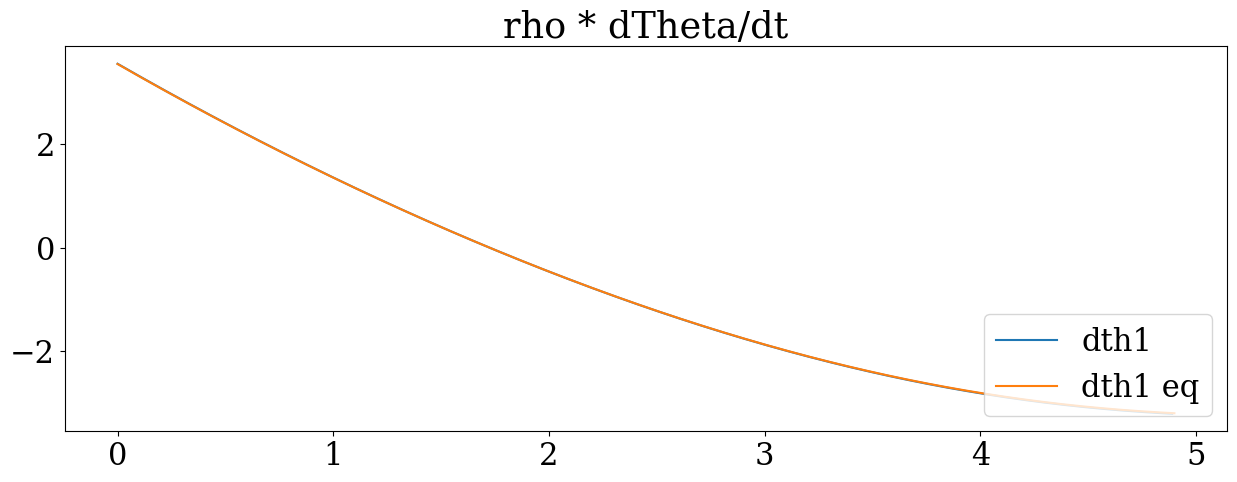

In [26]:
dth1 = np.diff(ths1) / dt * dists1[:-1]
dth1_eq = np.array([speed * np.sin(th) - eps * t * d1 for t, d1, th in zip(ts1, dists1, ths1)])

plt.title("rho * dTheta/dt")
plt.plot(ts1[:-1], dth1, label='dth1')
plt.plot(ts1, dth1_eq, label='dth1 eq')
plt.legend(loc='lower right')
plt.show()

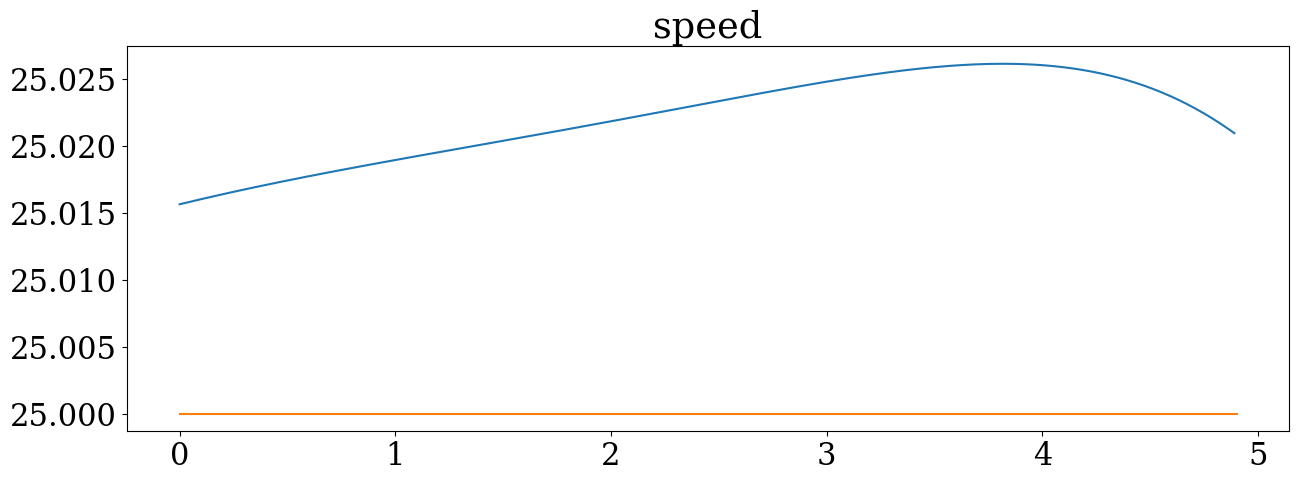

In [27]:
plt.title("speed")
plt.plot(ts1[:-1], (dth1 + eps * ts1[:-1] * dists1[:-1])**2 + ddists1**2)
plt.plot(ts1, np.ones_like(ts1) * speed ** 2)
plt.show()

In [28]:
def sign(a):
    s = np.sign(a)
    if isinstance(s, np.ndarray):
        s[s == 0] = 1
    else:
        if s == 0:
            s = 1
    return s

In [29]:
# theoretical theta
def th_eq(theta, ETA, omega, eps, t):
    z0 = theta - omega * ETA
    seps = -eps * sign(z0)
    k = theta + seps * ETA * ETA - omega * ETA
    return -seps * ts1 * ETA + theta + k * (np.exp(t / ETA) - 1)

# theoretical dtheta / dt
def dth_eq(theta, ETA, omega, eps, t):
    z0 = theta - omega * ETA
    seps = -eps * sign(z0)
    k = theta + seps * ETA * ETA - omega * ETA
    return (-seps * ETA + k / ETA * np.exp(t / ETA)) * dt

# direct rho * dtheta / dt mechanical equation
def drth_direct(theta, distance, omega, eps, t):
    return np.sin(theta) * speed - (omega + eps * t) * distance

# direct dtheta/dt mechanical equation
def dth_direct(theta, distance, omega, eps, t):
    return np.sin(theta) * speed / distance - (omega + eps * t)

# direct dtheta/dt mechanical equation
def dth_direct_bad(theta, distance, omega, eps, t):
    return (theta - 1/6 * theta**2) * speed / distance - (omega + eps * t)

def dth_direct_bad2(theta, distance, omega, eps, t):
    return (theta - 1/6 * theta**2) * speed / (distance - speed * np.cos(theta) * t) - (omega + eps * t)

In [30]:
# sim
dth1 = np.diff(ths1) / dt
drth1 = dth1 * dists1[:-1]
# mechanics
dth1_eq = np.array([dth_direct(th, d, omega0, eps, t) for t, th, d in zip(ts1, ths1, dists1)])
dth1_eqb1 = np.array([dth_direct_bad(th, d, omega0, eps, t) for t, th, d in zip(ts1, ths1, dists1)])
dth1_eqb2 = np.array([dth_direct_bad(th, dists1[0], omega0, eps, t) for t, th in zip(ts1, ths1)])
dth1_eqb3 = np.array([dth_direct_bad2(th, dists1[0], omega0, eps, t) for t, th in zip(ts1, ths1)])

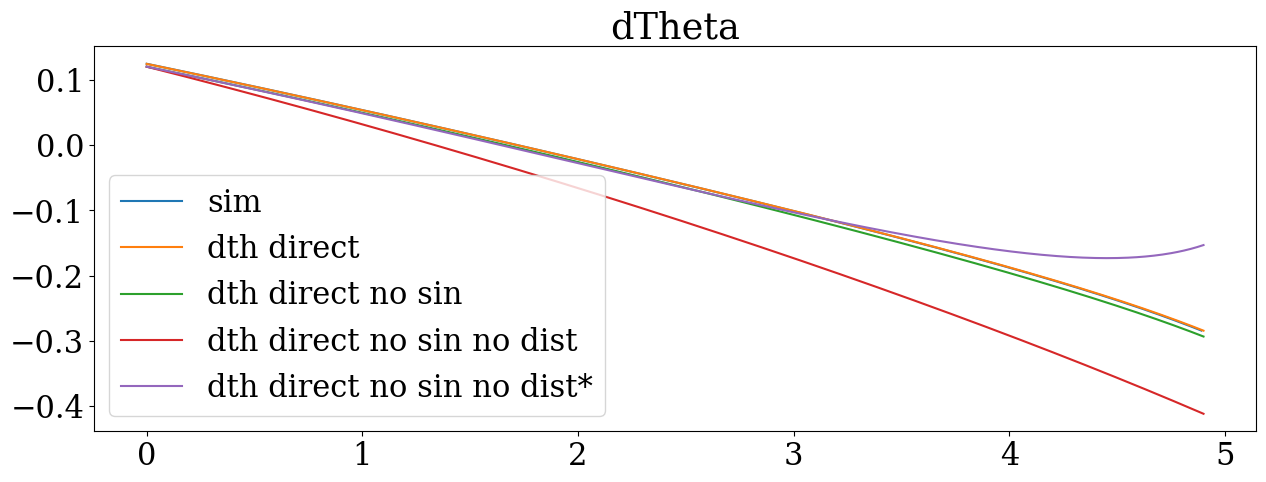

In [31]:
plt.title("dTheta")
plt.plot(ts1[:-1], dth1, label='sim')
plt.plot(ts1, dth1_eq, label='dth direct')
plt.plot(ts1, dth1_eqb1, label='dth direct no sin')
plt.plot(ts1, dth1_eqb2, label='dth direct no sin no dist')
plt.plot(ts1, dth1_eqb3, label='dth direct no sin no dist*')
plt.legend(loc='lower left')
plt.show()

In [66]:
def dth_wf_eq(theta, distance, speed, omega, eps, t):
    return speed / (distance - speed * cos(theta)) * theta - omega - eps * t

In [83]:
def th_wf(theta, distance, speed, omega, eps, t):
    pw = 1 / np.cos(theta)
    cos1 = 1 + np.cos(theta)
    cos2 = 2 * cos1 - 1
    c2 = distance ** pw * (theta - distance * (eps * distance + 2 * speed * omega * cos2) / (speed ** 2 * cos1 * cos2))
    c1 = distance
    rho_t = c1 - t * speed * cos(theta)
    theta_t = c2 * rho_t ** (-pw) + rho_t * (eps * rho_t + 2 * speed * (t * eps + omega) * cos2) / (speed ** 2 * cos1 * cos2)
    return theta_t

def rho_wf(theta, distance, speed, omega, eps, t):
    pw = 1 / np.cos(theta)
    cos1 = 1 + np.cos(theta)
    cos2 = 2 * cos1 - 1
    c2 = distance ** pw * (theta - distance * (eps * distance + 2 * speed * omega * cos2) / (speed ** 2 * cos1 * cos2))
    c1 = distance
    rho_t = c1 - t * speed * cos(theta)
    return rho_t

In [84]:
ths_wf = th_wf(theta0, abs(next_wp - pos), speed, omega0, eps, ts1)
rhos_wf = rho_wf(theta0, abs(next_wp - pos), speed, omega0, eps, ts1)

dths_wf_direct = np.array([dth_wf_eq(th, dists1[0], speed, omega0, eps, t) for t, th in zip(ts1, ths1)])

1.0104594136548875


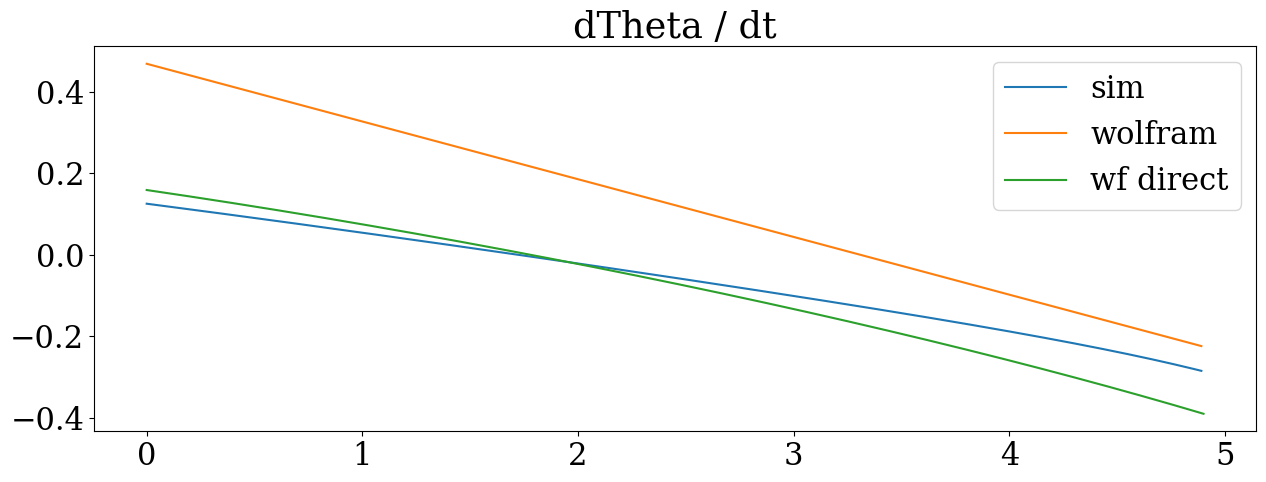

In [81]:
plt.title("dTheta / dt")
plt.plot(ts1[:-1], dth1, label='sim')
plt.plot(ts1[:-1], np.diff(ths_wf) / dt, label='wolfram')
plt.plot(ts1, dths_wf_direct, label='wf direct')
plt.legend(loc='upper right')
plt.show()

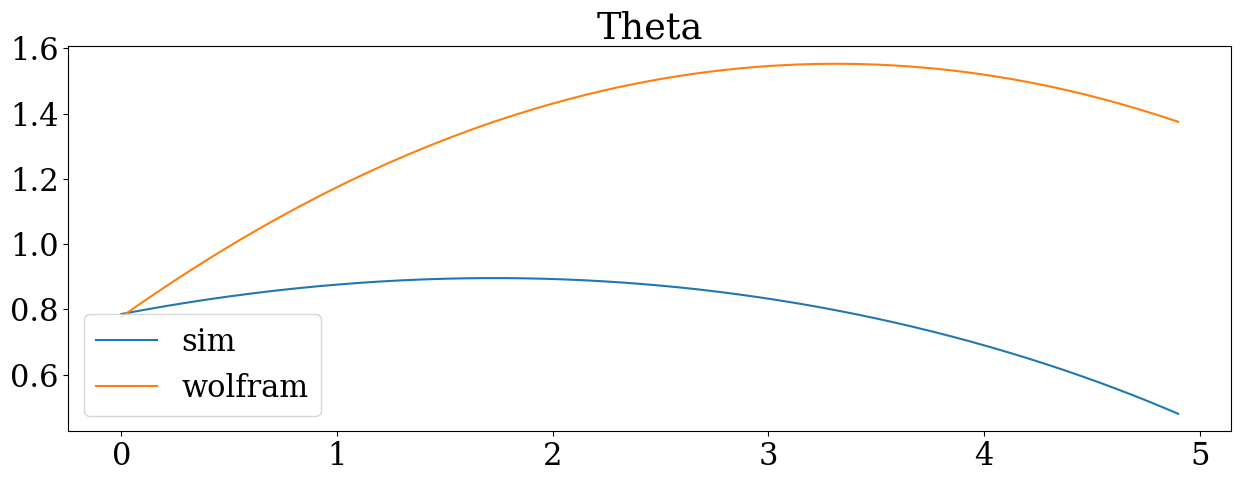

In [82]:
plt.title("Theta")
plt.plot(ts1, ths1, label='sim')
plt.plot(ts1, ths_wf, label='wolfram')
plt.legend(loc='lower left')
plt.show()

In [47]:
def damping_diff_angle(theta, ETA, omega, eps):
    z0 = theta + omega * ETA
    seps = -eps * sign(z0)
    k = z0 - seps * ETA * ETA
    if k < 0:
        print(f"AAAA! {theta}, {ETA}, {omega}, {eps}")
        return 0
    tau = ETA * np.log(eps * ETA * ETA / k)
    return -seps * tau * ETA + k * (np.exp(tau / ETA) - 1)

In [48]:
def damping_diff_angle_naive(theta, ETA, omega, eps):
    seps = -eps * sign(omega)
    tau = omega / seps
    return -seps * tau * tau / 2

In [49]:
dda = []
ddan = []
for i in range(xs1.shape[0]):
    theta = ths[i]
    dist = abs(next_wp - xs[i])
    ETA = dist / speed
    omega = ws[i]
    dda.append(damping_diff_angle(theta, ETA, omega, eps))
    ddan.append(damping_diff_angle_naive(theta, ETA, omega, eps))
dda = np.array(dda)
ddan = np.array(ddan)

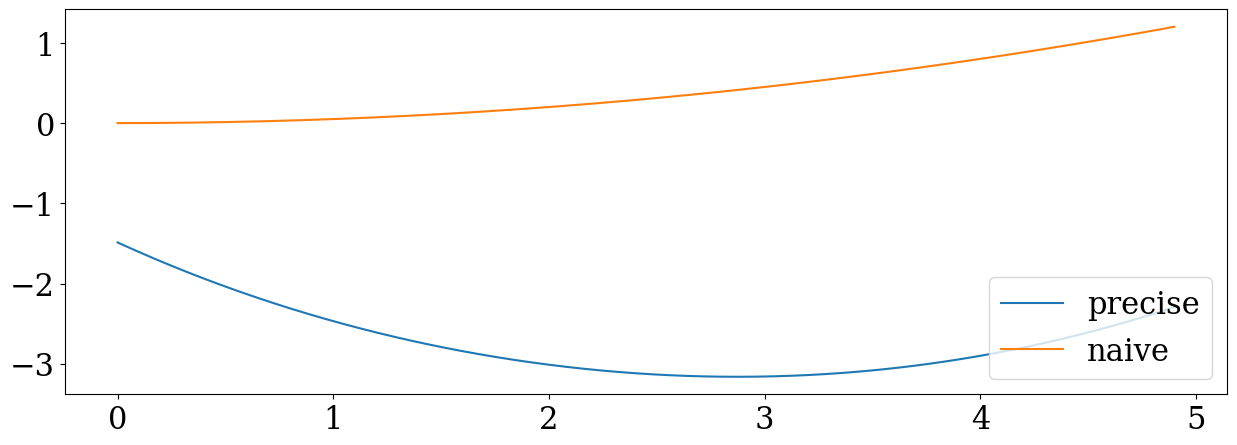

In [54]:
plt.plot(ts1, dda, label='precise')
plt.plot(ts1, ddan, label='naive')
plt.legend(loc='lower right')
plt.show()
# plt.plot(ts1, ths[:xs1.shape[0]])